# 支持向量机

### 杜小勤，武汉纺织大学数学与计算机学院，2020年03月09日
https://github.com/duxiaoqin/Lecture-notes-for-Machine-Learning

SMO算法的实现

In [1]:
import numpy as np
import random

In [2]:
class SVM:
    def __init__(self, C, tolerance, epsilon, max_step, kernel, sigma = 0.5):
        self.C = C #参数C
        self.tolerance = tolerance #容错率
        self.epsilon = epsilon #拉格朗日乘数更新的最小比率
        self.max_step = max_step #训练次数
        self.kernel = kernel #核函数类型：'linear'、'rbf'
        self.sigma = sigma
        
    #定义核函数
    #sample：单样本，行向量
    def Kernel(self, X, sample):
        if self.kernel == 'linear':
            result = np.dot(X, sample.T).reshape(-1, 1)
        elif self.kernel == 'rbf':
            result = np.exp(-np.linalg.norm(X - sample, ord = 2, axis = 1, keepdims = True)**2 / (2*self.sigma**2))
        else:
            result = None
            print('Non-legal kernel')
        return result
    
    #计算Gram矩阵
    def Gram(self, X):
        self.K = np.zeros((self.N, self.N))
        for i, x in enumerate(X):
            self.K[i, :] = self.Kernel(X, x).reshape(1, -1)
        
    #更新alpha1、alpha2、b、E
    #返回：成功更新，True；否则，False
    def update(self, index1, index2, X, Y):
        if (index1 == index2): #两个相同的拉格朗日乘数，无更新必要
            return False
        
        #取出乘数alpha
        alpha1 = self.alpha[index1][0]
        alpha2 = self.alpha[index2][0]
        #取出输入向量
        x1 = X[index1].reshape(-1, 1)
        x2 = X[index2].reshape(-1, 1)
        #取出标签
        y1 = Y[index1][0]
        y2 = Y[index2][0]
        #取出E
        E1 = self.E[index1][0]
        E2 = self.E[index2][0]
        #计算alpha的上界H与下界L
        if (y1 == y2):
            L = max(0, alpha2 + alpha1 - self.C)
            H = min(self.C, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        if (L == H): #相同的下界与上界，无更新必要
            return False
        #计算eta
        k11 = self.K[index1, index1]
        k22 = self.K[index2, index2]
        k12 = self.K[index1, index2]
        eta = k11 + k22 - 2 * k12
        if eta <= 0: #不更新
            return False
        alpha2_new = alpha2 + y2 * (E1 - E2) / eta #计算alpha2的新值
        alpha2_new = min(max(alpha2_new, L), H) #对alpha2进行[L, H]裁剪
        if abs(alpha2_new - alpha2) < self.epsilon * (alpha2_new + alpha2 + self.epsilon): #无更新必要
            return False
        alpha1_new = alpha1 + y1 * y2 * (alpha2 - alpha2_new) #计算alpha1的新值
        #计算b1和b2，并且更新b
        b1 = -E1 - y1 * k11 * (alpha1_new - alpha1) - y2 * k12 * (alpha2_new - alpha2) + self.b
        b2 = -E2 - y1 * k12 * (alpha1_new - alpha1) - y2 * k22 * (alpha2_new - alpha2) + self.b
        if alpha1_new > 0 and alpha1_new < self.C:
            self.b = b1
        elif alpha2_new > 0 and alpha2_new < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2
        #保存alpha1_new和alpha2_new，并确保约束>=0
        self.alpha[index1][0] = max(0, alpha1_new)
        self.alpha[index2][0] = max(0, alpha2_new)
        #更新E
        self.E = np.dot((self.alpha * Y).T, self.K).reshape(-1, 1) + self.b - Y
        return True
    
    #找出最佳的2个样本点，并启动更新
    #index：给定的第2个样本点索引
    def MatchTwoSamples(self, index, X, Y):
        y2 = Y[index][0]
        alpha2 = self.alpha[index][0]
        E2 = self.E[index][0]
        tol = E2 * y2 #容忍度：E*y=(g(x)-y)y=g(x)y-y^2=g(x)y-1，g(x)是y的实际输出值，两者越相似越好，此时tol接近0
        if ((tol < -self.tolerance and alpha2 < self.C) or (tol > self.tolerance and alpha2 > 0)): #不符合KKT条件，需调整
            #采取启发式方法，确定另一个乘数alpha1，找出满足0<alpha1<C的点
            list1 = np.nonzero(self.alpha)[0].tolist() #找出所有非0的alpha（索引）
            list2 = np.nonzero(self.alpha - self.C)[0].tolist() #找出所有非C的alpha（索引）
            result = list(set(list1) & set(list2))
            if len(result) > 1: #至少有2个及以上的候选点，选择一个最好的
                max_diff = -1
                max_index = -1
                for k in result:
                    diff = abs(self.E[k][0] - E2)
                    if diff > max_diff:
                        max_diff = diff
                        max_index = k
                if self.update(max_index, index, X, Y): #更新这2个乘数
                    return True
                #如果没有成功更新，则随机产生一个位置，逐个尝试每个乘数
                random_index = random.randint(0, len(result)-1)
                for k in range(random_index, len(result)):
                    if self.update(k, index, X, Y): #更新这2个乘数
                        return True
                for k in range(0, random_index):
                    if self.update(k, index, X, Y): #更新这2个乘数
                        return True
            random_index = random.randint(0, self.N-1) #从所有可能的乘数中，随机选择一个
            if self.update(random_index, index, X, Y): #更新这2个乘数
                return True
        return False
        
    def fit(self, X, Y):
        self.X = X #在使用核函数的情况下，需要保存数据集
        self.Y = Y
        self.N = len(X)
        self.b = 0
        self.alpha = np.zeros((self.N, 1))
        self.Gram(X) #计算Gram矩阵
        self.E = np.dot((self.alpha * Y).T, self.K).reshape(-1, 1) + self.b - Y #初始化E
        
        #开始训练
        self.paras = [] #存放中间权值的结果，用于生成动画
        for step in range(self.max_step):
            numChanged = 0
            everyone = True #确保第一次要全局遍历
            while numChanged > 0 or everyone:
                numChanged = 0
                if everyone:
                    for k in range(self.N):
                        numChanged += self.MatchTwoSamples(k, X, Y)
                        if self.kernel == 'linear':
                            self.paras.append((self.b, *np.dot(X.T, (self.alpha * Y)).reshape(1, -1).tolist())) #保存权值
                        else: #其它的核函数
                            self.paras.append((self.b, self.alpha)) #在使用其它核函数的情况下，只能保存每个样本对应的乘数alpha
                else:
                    for k in range(self.N):
                        if self.alpha[k] == 0 or self.alpha[k] == self.C:
                            continue
                        numChanged += self.MatchTwoSamples(k, X, Y)
                        if self.kernel == 'linear':
                            self.paras.append((self.b, *np.dot(X.T, (self.alpha * Y)).reshape(1, -1).tolist())) #保存权值
                        else: #其它的核函数
                            self.paras.append((self.b, self.alpha)) #在使用其它核函数的情况下，只能保存每个样本对应的乘数alpha
                if everyone:
                    everyone = False
                elif numChanged == 0:
                    everyone = True
        if self.kernel == 'linear': #计算W
            self.W = np.dot(X.T, (self.alpha * Y))
            print(self.b, self.W)
        print('SVM training completed!')
        
    def predict(self, X):
        result = []
        for x in X:
            z = np.dot((self.alpha * self.Y).T, self.Kernel(self.X, x)) + self.b
            result.append(1 if z >= 0 else -1)
        return result

载入预存的鸢尾花数据集

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
iris_npz = np.load('iris.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']
#转换成适合SVM处理的标签
Y[:50] = 1
Y[50:] = -1

In [5]:
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X, Y, test_size = 0.25)

使用训练数据训练“线性核SVM”

In [6]:
svm = SVM(1.0, 0.001, 0.01, 2, 'linear')
svm.fit(XTRAIN, YTRAIN.reshape(-1, 1))

5.17987952631 [[-2.26813742]
 [ 2.24382937]]
SVM training completed!


简单的预测测试

In [7]:
XSAMPLES = np.array([(5.5, 2.8), (5.5, 4.0), (4.5, 3.5), (6.5, 2.5)])
results = svm.predict(XSAMPLES)
print(results)

[-1, 1, 1, -1]


绘制SVM分类结果

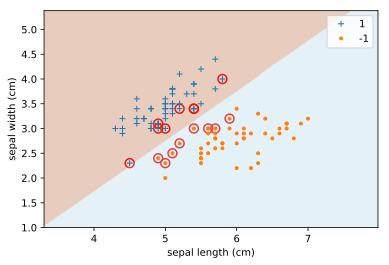

In [8]:
plt.plot(data[:50, 0], data[:50, 1], '+', label='1')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')

#绘制支持向量
for k, alpha in enumerate(svm.alpha):
    if alpha > 0.1:
        plt.scatter(XTRAIN[k][0], XTRAIN[k][1], s = 80, c = 'none', linewidth=1.5, edgecolor = 'red')
# 生成绘图用的网格
x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),
                       np.arange(x1_min, x1_max, 0.02))

z = np.array(svm.predict(np.c_[xx0.ravel(), xx1.ravel()]))
z = z.reshape(xx0.shape)
plt.contourf(xx0, xx1, z, cmap = plt.cm.Paired, alpha = 0.3)

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('SVM_OUTPUT1.pdf', bbox_inches='tight')

绘制训练动画

<IPython.core.display.Javascript object>


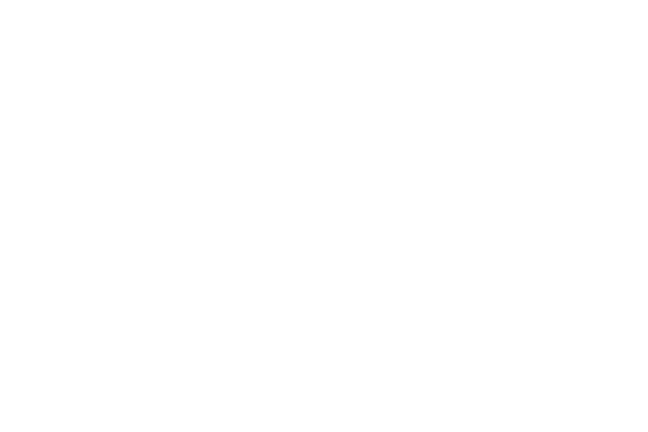

<IPython.core.display.Javascript object>


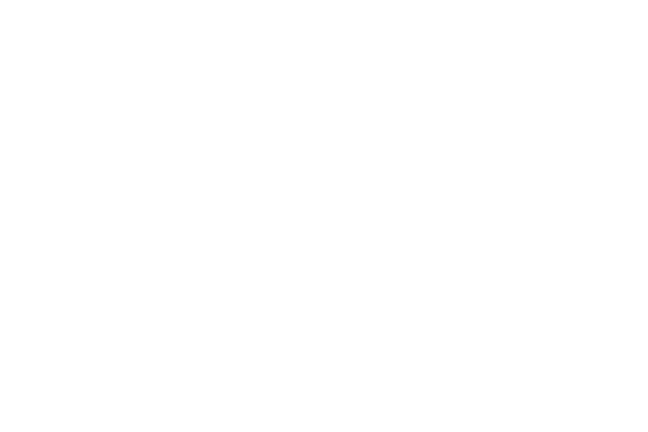

In [9]:
import matplotlib.animation as animation
from IPython.display import HTML
#动画播放，如果是%matplotlib inline，则会嵌入图片
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(xlim=(3, 7), ylim=(2, 5))

ax.plot(data[:50, 0], data[:50, 1], '+', label='1')
ax.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')
ax.set_title('Support Vector Machine')
ax.legend(loc = 'upper left')

line, = ax.plot([], [], lw = 2)
def update(para):
    b = para[0]
    W0 = para[1][0]
    W1 = para[1][1]
    if W1 == 0:
        return
    
    X_points = np.linspace(4, 7,10)
    Y_points = -(W0 * X_points + b)/W1
    line.set_data(X_points, Y_points)
ani = animation.FuncAnimation(fig, update, svm.paras)
#视频播放
#安装FFMPEG库
#在anaconda环境下，需要执行“conda install -c conda-forge ffmpeg”
#需要FFMPEG.exe，直接下载BUILD，解压到目录，例如E:\ffmpeg\bin
#然后在环境变量PATH中添加“E:\ffmpeg\bin”，路径名称需要根据实际情况做相应的调整
HTML(ani.to_html5_video())

In [10]:
ani.save('Fitting-duxiaoqin.mp4')

使用鸢尾花测试数据集进行测试

In [11]:
from collections import Counter

results = svm.predict(XTEST)
scores = (results == YTEST)
scores = [score for score in scores]
print('Accuracy = {:3.2f}%'.format(Counter(scores)[True]/len(YTEST) * 100))

Accuracy = 100.00%


使用训练数据训练“RBF核SVM”

In [12]:
svm = SVM(1.0, 0.001, 0.01, 2, 'rbf', sigma = 1.0)
svm.fit(XTRAIN, YTRAIN.reshape(-1, 1))

SVM training completed!


简单的预测测试

In [13]:
XSAMPLES = np.array([(5.5, 2.8), (5.5, 4.0), (4.5, 3.5), (6.5, 2.5)])
results = svm.predict(XSAMPLES)
print(results)

[-1, 1, 1, -1]


使用鸢尾花测试数据集进行测试

In [14]:
results = svm.predict(XTEST)
scores = (results == YTEST)
scores = [score for score in scores]
print('Accuracy = {:3.2f}%'.format(Counter(scores)[True]/len(YTEST) * 100))

Accuracy = 100.00%


绘制SVM分类结果

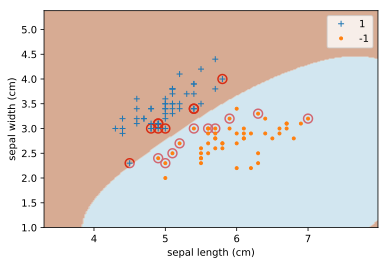

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.plot(data[:50, 0], data[:50, 1], '+', label='1')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')

#绘制支持向量
for k, alpha in enumerate(svm.alpha):
    if alpha > 0.1:
        plt.scatter(XTRAIN[k][0], XTRAIN[k][1], s = 80, c = 'none', linewidth=1.5, edgecolor = 'red')

# 生成绘图用的网格
x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),
                       np.arange(x1_min, x1_max, 0.02))

z = np.array(svm.predict(np.c_[xx0.ravel(), xx1.ravel()]))
z = z.reshape(xx0.shape)
plt.contourf(xx0, xx1, z, cmap = plt.cm.Paired, alpha = 0.5)

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.xlim(xx0.min(), xx0.max())
plt.ylim(xx1.min(), xx1.max())
plt.legend()
plt.savefig('SVM_OUTPUT2.pdf', bbox_inches='tight')

使用sklearn.svm.SVC进行分类

使用说明

参数：

- C：C-SVC的惩罚参数C?默认值是1.0

C越大，相当于惩罚松弛变量，使得松弛变量向0靠拢，即对误分类的惩罚增大，准确率会提高，但泛化能力将减弱；C值小，对误分类的惩罚减小，允许一定的容错，但是泛化能力将增强；

- kernel：核函数，默认是rbf，可以是‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ 
    
    – 线性：u'v
    
    – 多项式：(gamma*u'*v + coef0)^degree

    – RBF函数：exp(-gamma|u-v|^2)

    – sigmoid：tanh(gamma*u'*v + coef0)

- degree ：多项式poly函数的维度，默认是3，选择其他核函数时会被忽略。

- gamma：‘rbf’,‘poly’ 和‘sigmoid’的核函数参数。默认是’auto’，则会选择1/n_features

- coef0：核函数的常数项。对于‘poly’和 ‘sigmoid’有用。

- tol：停止训练的误差值大小，默认为1e-3

主要的调节参数：C、kernel、degree、gamma、coef0。

使用数据集训练“线性核SVM”

In [16]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear')
clf.fit(XTRAIN, YTRAIN)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

训练结果：分类决策面

In [17]:
print(clf.coef_, clf.intercept_)

[[-2.22261578  2.22261101]] [ 5.00093675]


绘制SVM分类结果

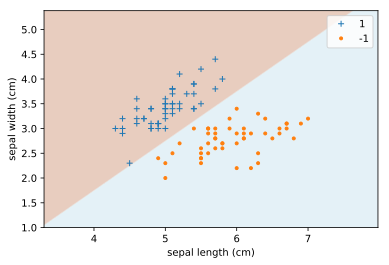

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(data[:50, 0], data[:50, 1], '+', label='1')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')

# 生成绘图用的网格
x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),
                       np.arange(x1_min, x1_max, 0.02))

z = clf.predict(np.c_[xx0.ravel(), xx1.ravel()])
z = z.reshape(xx0.shape)
plt.contourf(xx0, xx1, z, cmap = plt.cm.Paired, alpha = 0.3)

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('SVM_OUTPUT3.pdf', bbox_inches='tight')

使用测试数据进行测试

In [19]:
clf.score(XTEST, YTEST)

1.0

使用数据集训练“RBF核SVM”

In [20]:
clf = SVC(kernel = 'rbf')
clf.fit(XTRAIN, YTRAIN)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

使用测试数据进行测试

In [21]:
clf.score(XTEST, YTEST)

1.0

绘制SVM分类结果

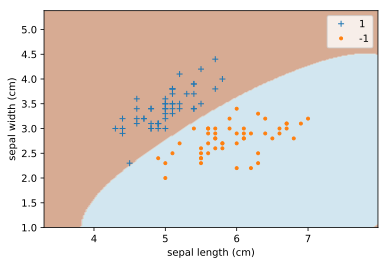

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(data[:50, 0], data[:50, 1], '+', label='1')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='-1')

# 生成绘图用的网格
x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),
                       np.arange(x1_min, x1_max, 0.02))

z = clf.predict(np.c_[xx0.ravel(), xx1.ravel()])
z = z.reshape(xx0.shape)
plt.contourf(xx0, xx1, z, cmap = plt.cm.Paired, alpha = 0.5)

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('SVM_OUTPUT4.pdf', bbox_inches='tight')

参考文献：

- https://github.com/wzyonggege/statistical-learning-method
- https://blog.csdn.net/wolfcsharp/article/details/90181429
- 《统计学习方法》，李航，清华大学出版社，2012年3月第1版；
- 《Machine Learning in Action》，Peter Harrington，2012；
- https://www.zybuluo.com/Duanxx/note/433281
- [Lagrange Multiplier and KKT](http://blog.csdn.net/xianlingmao/article/details/7919597)

- [推导SVM](https://my.oschina.net/dfsj66011/blog/517766)

- [机器学习算法实践-支持向量机(SVM)算法原理](http://pytlab.org/2017/08/15/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E7%AE%97%E6%B3%95%E5%AE%9E%E8%B7%B5-%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%9C%BA-SVM-%E7%AE%97%E6%B3%95%E5%8E%9F%E7%90%86/)

- [Python实现SVM](http://blog.csdn.net/wds2006sdo/article/details/53156589)